## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
cptac.download(dataset='colon')

All files already downloaded and correct.


True

In [3]:
co = cptac.Colon()
proteomics = co.get_proteomics()
transcriptomics = co.get_transcriptomics()
clinical = co.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())

In [5]:
annotations = annotations.drop(['Patient_ID'], axis=1)

In [6]:
already_binary_columns = ['Mutation_Phenotype', 'Tumor.Status', 
                          'Vital.Status', 'Polyps_Present', 
                          'Polyps_History', 'Synchronous_Tumors', 
                          'Perineural_Invasion', 'Lymphatic_Invasion', 
                          'Vascular_Invasion', 'Mucinous', 'Gender', 
                          'Sample_Tumor_Normal']

#should pathalogy_T_stage be pathology_T_stage??
columns_2_binarize = ['Age', 'Subsite', 
                      'pathalogy_T_stage',
                      'pathalogy_N_stage', 
                      'Stage', 'CEA', 
                      'Transcriptomic_subtype', 
                      'Proteomic_subtype', 
                      'mutation_rate']

## Step 2a: Binarize column values

Clean up columns that are strings, that should be numerics

In [7]:
clinical['CEA'] = pd.to_numeric(clinical['CEA'])
clinical['Age'] = pd.to_numeric(clinical['Age'])
clinical['mutation_rate'] = pd.to_numeric(clinical['mutation_rate'])

In [8]:
annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       730, '2 years or older', 
                                       'Younger than 2 years')

In [9]:
subsite_map = {'Sigmoid Colon':'Sigmoid_Colon', 
               'Ascending Colon':'Other_site', 
               'Cecum ':'Other_site', 
               'Descending Colon':'Other_site', 
               'Hepatix Flexure':'Other_site', 
               'Splenic Flexure':'Other_site', 
               'Tranverse Colon':'Other_site'}

annotations['Subsite'] = bf.binarizeCategorical(clinical, 
                                                'Subsite', 
                                                subsite_map)

In [10]:
pathalogy_T_stage_map = {'T3':'T3orT2', 'T2':'T3orT2', 
                         'T4a':'T4', 'T4b':'T4'}

annotations['pathalogy_T_stage'] = bf.binarizeCategorical(clinical, 
                                                          'pathalogy_T_stage', 
                                                          pathalogy_T_stage_map)

In [11]:
pathalogy_N_stage_map = {'N0':'N0', 'N1':'N1orN2',
                         'N1a':'N1orN2', 'N1b':'N1orN2', 
                         'N2a':'N1orN2', 'N2b':'N1orN2'}

annotations['pathalogy_N_stage'] = bf.binarizeCategorical(clinical, 
                                                          'pathalogy_N_stage', 
                                                          pathalogy_N_stage_map)

In [12]:
stage_map = {'Stage I':'StageIorII', 
             'Stage II':'StageIorII', 
             'Stage III':'StageIIIorIV', 
             'Stage IV':'StageIIIorIV'}

annotations['Stage'] = bf.binarizeCategorical(clinical, 
                                              'Stage', 
                                              stage_map)

In [13]:
annotations['CEA'] = bf.binarizeCutOff(clinical, 
                                       'CEA', 15, 
                                       'High_CEA', 
                                       'Low_CEA')

In [14]:
Transcriptomic_subtype_map = {'CMS1':'CMS1or2', 
                              'CMS2':'CMS1or2', 
                              'CMS3':'CMS3or4', 
                              'CMS4':'CMS3or4'}

annotations['Transcriptomic_subtype'] = bf.binarizeCategorical(clinical, 
                                                               'Transcriptomic_subtype', 
                                                               Transcriptomic_subtype_map)

In [15]:
Proteomic_subtype_map = {'A':'AorBorC', 
                         'B':'AorBorC', 
                         'C':'AorBorC', 
                         'D':'DorE', 
                         'E':'DorE'}

annotations['Proteomic_subtype'] = bf.binarizeCategorical(clinical, 
                                                          'Proteomic_subtype', 
                                                          Proteomic_subtype_map)

In [16]:
annotations['mutation_rate'] = bf.binarizeCutOff(clinical, 
                                                 'mutation_rate', 50, 
                                                 'High_Mutation_Rate', 
                                                 'Low_Mutation_Rate')

## Step 3: Perform outliers analysis

In [17]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_trans = blsh.make_outliers_table(transcriptomics, iqrs=1.5, 
                                          up_or_down='up', 
                                          aggregate=False, 
                                          frac_table=False)

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [18]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Normal samples
Testing 2 rows for enrichment in Age 2 years or older samples
Testing 4 rows for enrichment in Age Younger than 2 years samples
Testing 2 rows for enrichment in Gender Female samples
Testing 3 rows for enrichment in Gender Male samples
Testing 1 rows for enrichment in Mucinous Not Mucinous samples
Testing 54 rows for enrichment in Mucinous Mucinous samples
Testing 3 rows for enrichment in Subsite Other_site samples
Testing 5 rows for enrichment in Subsite Sigmoid_Colon samples
No rows had outliers in at least 0.3 of pathalogy_T_stage T3orT2 samples
Testing 43 rows for enrichment in pathalogy_T_stage T4 samples
Testing 2 rows for enrichment in pathalogy_N_stage N0 samples
Testing 5 rows for enrichment in pathalogy_N_stage N1orN2 samples
Testing 4 rows for enrichment in Stage StageIIIorIV samples
Testing 3 rows for enrichment in Stage StageI

In [19]:
results_trans = blsh.compare_groups_outliers(outliers_trans, 
                                             annotations)

No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of Age 2 years or older samples
Testing 2 rows for enrichment in Age Younger than 2 years samples
No rows had outliers in at least 0.3 of Gender Female samples
No rows had outliers in at least 0.3 of Gender Male samples
No rows had outliers in at least 0.3 of Mucinous Not Mucinous samples
No rows had outliers in at least 0.3 of Mucinous Mucinous samples
No rows had outliers in at least 0.3 of Subsite Other_site samples
No rows had outliers in at least 0.3 of Subsite Sigmoid_Colon samples
No rows had outliers in at least 0.3 of pathalogy_T_stage T3orT2 samples
Testing 1 rows for enrichment in pathalogy_T_stage T4 samples
No rows had outliers in at least 0.3 of pathalogy_N_stage N0 samples
No rows had outliers in at least 0.3 of pathalogy_N_stage N1orN2 samples
No rows had outliers in at least 0.3 of Stag

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [20]:
results_prot = results_prot.dropna(axis=0, how='all')
results_trans = results_trans.dropna(axis=0, how='all')

In [26]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) > 5:
        sig_cols.append(sig_col)
        print(sig_col)
    else:
        results_prot = results_prot.drop(col, axis=1)

TESTING FOR PROTEOMICS:
8 significant protein enrichments in Proteomic_subtype_DorE

         Proteomic_subtype_DorE_P_values
CLPP                            0.004933
ERAL1                           0.004933
FAM210B                         0.004933
FERMT1                          0.008352
TIMM13                          0.004933
TKFC                            0.008352
UBA2                            0.007530
YWHAB                           0.004933
57 significant protein enrichments in mutation_rate_High_Mutation_Rate

          mutation_rate_High_Mutation_Rate_P_values
ADGRE5                                     0.007492
ANP32E                                     0.007491
APOBEC3G                                   0.006239
ATP6V1E1                                   0.008704
CDC73                                      0.007491
CDCP1                                      0.006239
CHORDC1                                    0.001451
DNAJC1                                     0.008704
EIF5A 

## Step 5: Visualize these enrichments

In [34]:
MSI_H_sig_enrichments = sig_cols[-1]
sig_genes_MSI_H = list(MSI_H_sig_enrichments.index)
r = bf.dgidb_get_request(sig_genes_MSI_H)

This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ADGRE5,ADSS,ANP32E,APOL2,ARHGEF1,ARHGEF2,ASPH,ATP6V1A,BPI,CACYBP,CCT3,CDC73,CDCP1,CHORDC1,CLUH,CTR9,CYBB,DEFA1B,EIF3H,EIF5A,ENO1,EPHA2,FDPS,FMNL1,FSCN1,FUT8,GALNT1,GBP1,GBP4,GBP5,GYS1,HAT1,HID1,HSP90AA1,HSPA5,IFI35,IL4I1,ITGAM,ITGB2,IVNS1ABP,KLC2,KRT7,LAMA3,LARP4,LCP2,LPCAT1,LUC7L,MAN1A2,MAP2K3,MBOAT7,MCM2,MCM3,MCM4,MCM6,MCM7,MIA3,MMP1,MMP2,MMP8,MOV10,MTHFD1,MUC1,MUC5AC,MUC5B,MX1,NADK,NCF1,NCF2,NCF4,NCLN,NDUFA4L2,NEMF,NFATC2IP,NFKB2,NMD3,NMI,NUDC,NUP210,NUP50,P4HA1,PADI4,PAPSS1,PARP14,PARP9,PCBP2,PCSK9,PGD,PHAX,PKM,PLEK,PLEK2,PRRC1,PSAT1,PSMB1,PSMB10,PSMC2,PSMC5,PSMC6,PSMD1,QSOX1,RBBP4,RFC1,RFC4,RPL22L1,RRM1,S100A16,SCAMP2,SCAMP3,SCYL1,SEC16A,SEC24D,SERPINB1,SERPINB5,SERPINB8,SIGLEC5,SLC16A3,SLC30A7,SLC31A1,SMCHD1,SSFA2,STAT1,STK10,STMN1,TAP1,TAP2,TBC1D2,TCF25,TIMP1,TMEM2,TMX1,TSR1,TYMP,UBA6,UBE2L6,UGT8,UHRF1,WARS,ZC3HAV1
If this request failed, it is likely due to invalid inputs for gene_cate

In [35]:
r.json()

{'ambiguousTerms': [],
 'matchedTerms': [{'entrezId': 976,
   'geneCategories': [{'id': 'b258740aae5a4b0c8a0a82c3dcf01918',
     'name': 'G PROTEIN COUPLED RECEPTOR'},
    {'id': 'd3ec2631e0b2434b9dcc008e793d3fa5', 'name': 'DRUGGABLE GENOME'}],
   'geneLongName': 'ADHESION G PROTEIN-COUPLED RECEPTOR E5',
   'geneName': 'ADGRE5',
   'interactions': [],
   'searchTerm': 'ADGRE5'},
  {'entrezId': 159,
   'geneCategories': [],
   'geneLongName': 'ADENYLOSUCCINATE SYNTHASE',
   'geneName': 'ADSS',
   'interactions': [{'drugChemblId': 'CHEMBL452715',
     'drugName': 'ALANOSINE',
     'interactionId': '2e48b57c-12e7-4acc-b831-dba33cb2665f',
     'interactionTypes': [],
     'pmids': [7825060],
     'score': 2,
     'sources': ['NCI']},
    {'drugChemblId': 'CHEMBL274323',
     'drugName': 'ASPARTIC ACID',
     'interactionId': '5af75cca-e278-43e3-84f0-c5fa2c60f4ef',
     'interactionTypes': [],
     'pmids': [15500910, 17929831, 17139284, 7825060, 17016423],
     'score': 6,
     'sources': 

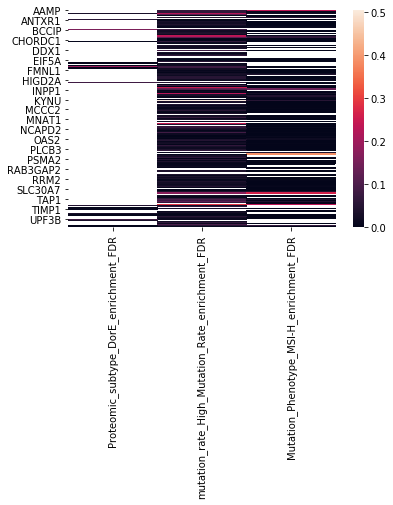

In [22]:
sns.heatmap(results_prot)
plt.show()

In [24]:
print("TESTING FOR TRANSCRIPTOMICS:")
sig_cols = []
for col in results_trans.columns:
    sig_col = bf.significantEnrichments(results_trans, col, 0.01)
    if sig_col is not None and len(sig_col) > 5:
        sig_cols.append(sig_col)
    else:
        results_trans = results_trans.drop(col, axis=1)

TESTING FOR TRANSCRIPTOMICS:
1 significant protein enrichment in pathalogy_T_stage_T4:

67 significant protein enrichments in mutation_rate_High_Mutation_Rate

2 significant protein enrichments in Vital.Status_Deceased

9 significant protein enrichments in Tumor.Status_With tumor

19 significant protein enrichments in Mutation_Phenotype_MSI-H



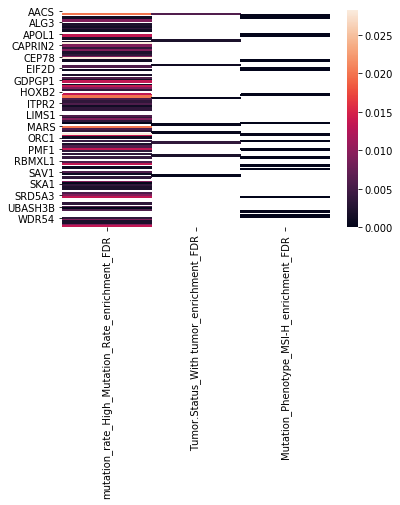

In [25]:
sns.heatmap(results_trans)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [26]:
'''for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/enrichr_kegg', #This isn't saving correctly...why is that?
                            cutoff=0.5)
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)
'''

"for col in sig_cols:\n    col_name = col.columns[0]\n    gene_name_list = list(col.index)\n    enrichment = gp.enrichr(gene_list = gene_name_list, \n                            description=col_name, \n                            gene_sets='KEGG_2019_Human', \n                            outdir='test/enrichr_kegg', #This isn't saving correctly...why is that?\n                            cutoff=0.5)\n    print(enrichment.res2d)\n    barplot(enrichment.res2d, title=col_name)\n"

## Here, we will query the Drug Gene Interactive Database (DGIdb) to find interactions, drugs, and other useful information in regards to these genes:

In [ ]:
bf.dgidb_get_request()